In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool, cv
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Load Dataset

In [3]:
# 데이터 로드
df_trn = pd.read_csv('train.csv')
df_tst = pd.read_csv('test.csv')

In [4]:
df_trn.head()

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,label
0,train00001,34,blue-collar,married,primary,no,358,yes,no,unknown,23,may,100,4,-1,0,unknown,0
1,train00002,33,blue-collar,married,secondary,no,-53,yes,no,unknown,20,may,172,1,-1,0,unknown,0
2,train00003,32,management,single,tertiary,no,207,yes,no,cellular,2,feb,56,1,-1,0,unknown,0
3,train00004,37,blue-collar,divorced,secondary,no,638,yes,no,cellular,8,may,326,1,326,2,success,0
4,train00005,33,housemaid,married,secondary,no,826,yes,no,cellular,11,may,256,1,-1,0,unknown,0


In [5]:
df_tst.head()

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,label
0,test00001,54,management,divorced,tertiary,no,6410,no,no,cellular,20,nov,101,2,-1,0,unknown,NaN
1,test00002,56,unemployed,divorced,primary,no,282,no,no,cellular,28,jan,156,2,-1,0,unknown,NaN
2,test00003,34,management,married,secondary,no,355,no,no,cellular,21,aug,314,3,-1,0,unknown,NaN
3,test00004,55,management,married,tertiary,no,568,no,no,cellular,12,aug,940,10,-1,0,unknown,NaN
4,test00005,38,technician,married,secondary,no,6728,no,no,cellular,21,aug,252,4,-1,0,unknown,NaN


# 2. EDA

In [7]:
df_trn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31647 entries, 0 to 31646
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         31647 non-null  object
 1   age        31647 non-null  int64 
 2   job        31647 non-null  object
 3   marital    31647 non-null  object
 4   education  31647 non-null  object
 5   default    31647 non-null  object
 6   balance    31647 non-null  int64 
 7   housing    31647 non-null  object
 8   loan       31647 non-null  object
 9   contact    31647 non-null  object
 10  day        31647 non-null  int64 
 11  month      31647 non-null  object
 12  duration   31647 non-null  int64 
 13  campaign   31647 non-null  int64 
 14  pdays      31647 non-null  int64 
 15  previous   31647 non-null  int64 
 16  poutcome   31647 non-null  object
 17  label      31647 non-null  int64 
dtypes: int64(8), object(10)
memory usage: 4.3+ MB


In [8]:
df_tst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13564 entries, 0 to 13563
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         13564 non-null  object 
 1   age        13564 non-null  int64  
 2   job        13564 non-null  object 
 3   marital    13564 non-null  object 
 4   education  13564 non-null  object 
 5   default    13564 non-null  object 
 6   balance    13564 non-null  int64  
 7   housing    13564 non-null  object 
 8   loan       13564 non-null  object 
 9   contact    13564 non-null  object 
 10  day        13564 non-null  int64  
 11  month      13564 non-null  object 
 12  duration   13564 non-null  int64  
 13  campaign   13564 non-null  int64  
 14  pdays      13564 non-null  int64  
 15  previous   13564 non-null  int64  
 16  poutcome   13564 non-null  object 
 17  label      0 non-null      float64
dtypes: float64(1), int64(7), object(10)
memory usage: 1.9+ MB


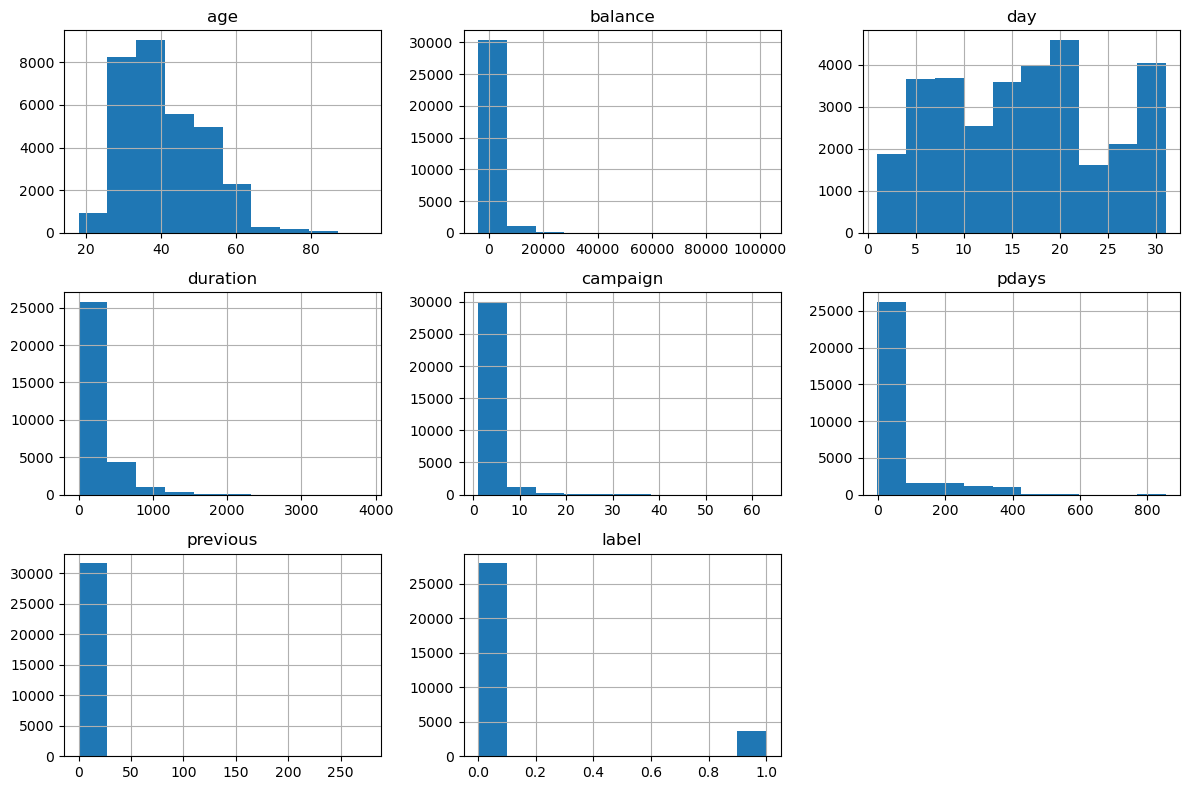

In [9]:
df_trn.hist(figsize=(12,8))
plt.tight_layout()

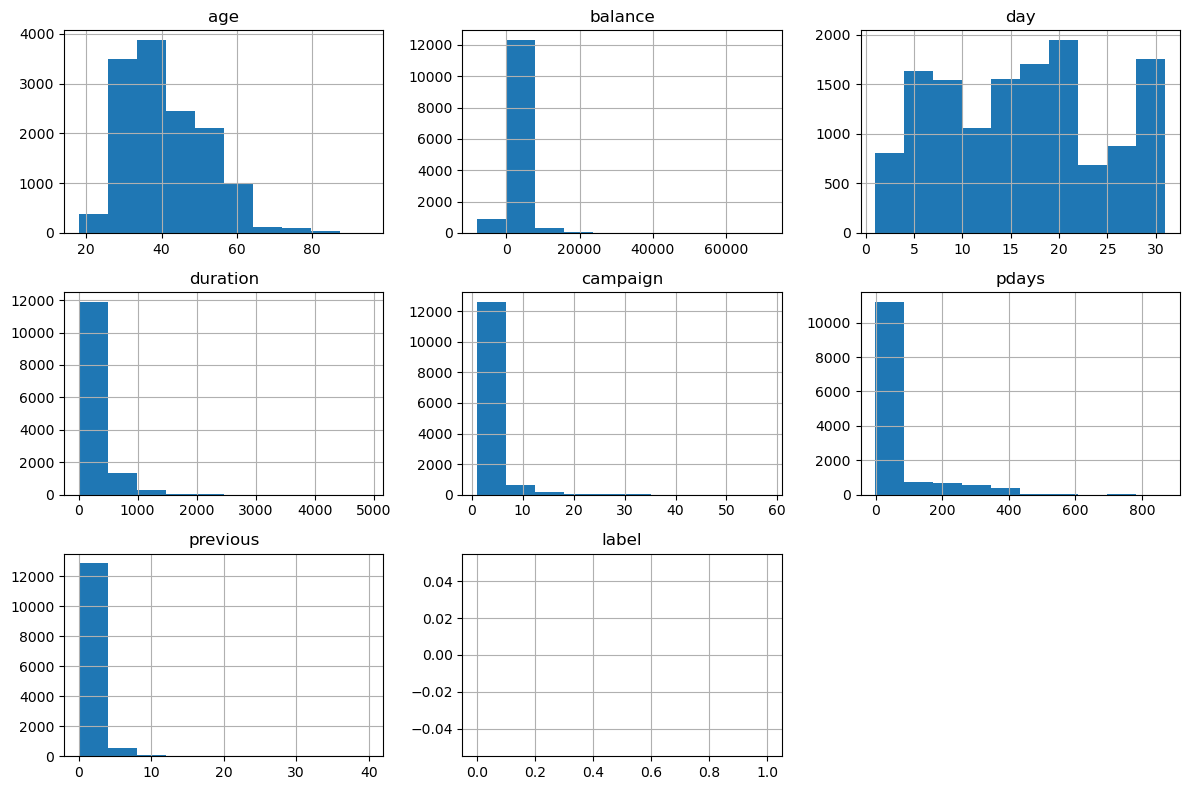

In [10]:
df_tst.hist(figsize=(12,8))
plt.tight_layout()

In [11]:
# ID와 Target 컬럼 제거
id_cols = ['ID']  # ID 따로 저장
y_cols = ['label']

# 범주형 변수 및 수치형 변수 정의
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
            'month', 'poutcome']   # 범주형
num_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']  # 수치형

## 파생 변수(유도 변수) 확인

In [13]:
## 1. `long_duration`: duration이 중위값보다 큰지 여부
df_trn['long_duration'] = (df_trn['duration'] > df_trn['duration'].median()).astype(int)
df_tst['long_duration'] = (df_tst['duration'] > df_tst['duration'].median()).astype(int)

In [14]:
# 2. `duration_diff`: duration에서 직업군 평균 duration 차이
job_stats = df_trn.groupby('job')['duration'].mean().rename('job_avg_duration')
df_trn = df_trn.merge(job_stats, on='job', how='left')
df_tst = df_tst.merge(job_stats, on='job', how='left')

df_trn['duration_diff'] = df_trn['duration'] - df_trn['job_avg_duration']
df_tst['duration_diff'] = df_tst['duration'] - df_tst['job_avg_duration']

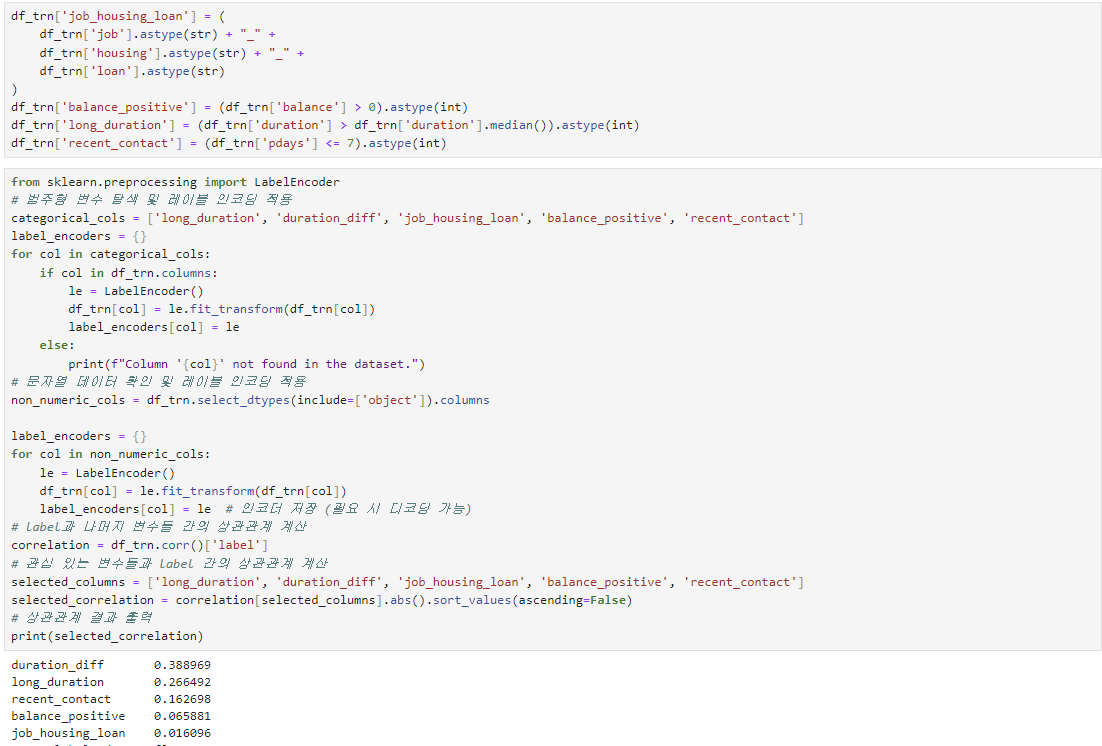

### 만든 파생변수 중에 'label'과의 상관관계가 가장 높은 것: duration_diff와 long_duration만 파생 변수로 선택

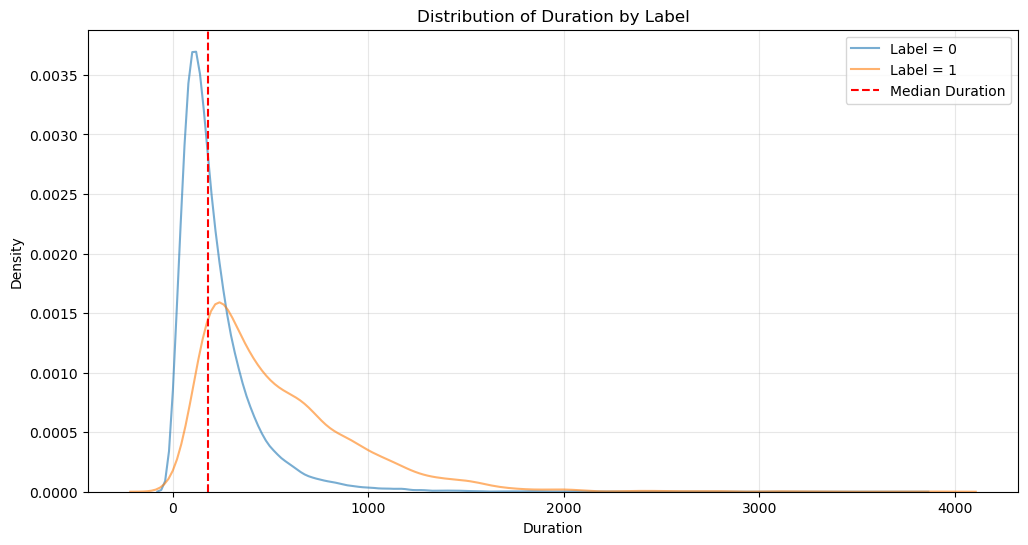

In [17]:
# duration의 중앙값 계산
duration_median = df_trn['duration'].median()

# label에 따른 duration의 분포 비교
plt.figure(figsize=(12, 6))
sns.kdeplot(df_trn[df_trn['label'] == 0]['duration'], label='Label = 0', alpha=0.6)
sns.kdeplot(df_trn[df_trn['label'] == 1]['duration'], label='Label = 1', alpha=0.6)
plt.axvline(duration_median, color='red', linestyle='--', label='Median Duration')
plt.title('Distribution of Duration by Label')
plt.xlabel('Duration')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

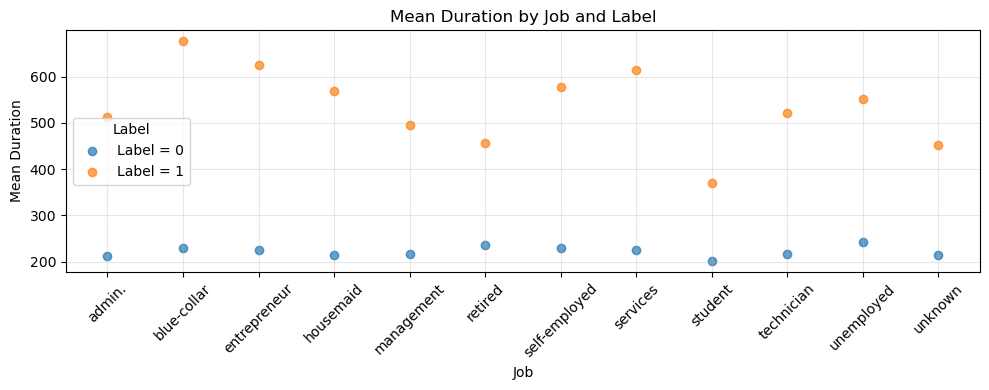

In [18]:
# duration의 평균과 job, label 간의 관계를 나타내기 위한 데이터 그룹화
grouped_data = df_trn.groupby(['job', 'label'])['duration'].mean().reset_index()

# 산점도로 시각화
plt.figure(figsize=(10, 4))
for label in grouped_data['label'].unique():
    subset = grouped_data[grouped_data['label'] == label]
    plt.scatter(subset['job'], subset['duration'], label=f'Label = {label}', alpha=0.7)

plt.title('Mean Duration by Job and Label')
plt.ylabel('Mean Duration')
plt.xlabel('Job')
plt.xticks(rotation=45)
plt.legend(title='Label')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

- duration_diff: 직업별 평균 duration과의 차이
- job_stats: train 데이터에서 job별로 duration의 평균
- train.merge(job_stats, on='job', how='left'): train 데이터와 job_stats를 job 기준으로 합침. (각 job마다 평균 duration을 train 데이터에 추가)
- train['duration_diff']: duration에서 job_avg_duration을 빼는 방식으로 duration_diff라는 새로운 변수(각각의 직업군 평균 duration과의 차이) 생성
- 테스트 데이터에서도 동일하게 적용

In [20]:
# 추가된 파생 변수 포함
num_cols += ['long_duration', 'duration_diff']

In [21]:
# 로그 변환
def safe_log1p(x):
    return np.log1p(np.maximum(x, 1e-6))

- 로그 변환 함수 정의
  - safe_log1p: log1p는 log(1+x)와 같은 함수인데, 여기에 np.maximum(x, 1e-6)을 적용하여 x가 0 이하일 경우 0으로 계산되는 문제를 방지
  - 로그 변환을 안전하게 적용 가능
  - np.log1p: 자연로그를 적용하는 함수로, log(1+x)의 형태로 계산
1. np.maximum(x, 1e-6)
np.maximum은 두 값 중 더 큰 값을 반환하는 함수
이 코드에서 x와 1e-6 (즉, 0.000001) 중 더 큰 값을 선택
이를 통해 x 값이 0 이하일 경우에도 문제가 발생하지 않도록 보장 
2. np.log1p(x)
np.log1p(x)는 log(1 + x)와 동일 (즉, x + 1에 대해 자연 로그를 취하는 함수)
log1p는 log(1 + x)보다 더 정확한 계산을 제공하는데, 특히 x가 작은 값일 때 수치적인 안정성을 제공
예를 들어, log(1 + 0.000001)을 계산할 때, log1p를 사용하면 오차가 적음
4. 함수의 목적
이 함수는 x가 음수일 경우, 또는 x가 0일 경우에도 안전하게 로그 변환을 할 수 있도록 도와줌
x가 0일 경우에 log(0)은 수학적으로 정의되지 않기 때문에, 이를 방지하기 위해 x가 1e-6 이하인 값들은 1e-6로 대체하고 그 후에 log1p를 적용
safe_log1p(x)는 x가 0 이하일 때 log(0) 같은 문제를 방지하고, 매우 작은 값에 대해서도 안정적으로 로그 변환을 수행하기 위한 함수

In [23]:
preprocessor = ColumnTransformer([
    ('num_pipeline', Pipeline([
        ('log_transform', FunctionTransformer(safe_log1p, validate=True)),
        ('scaler', StandardScaler())
    ]), num_cols)
], remainder='drop')  # 'drop'으로 passthrough 제거

## 수치형 변수 전처리
- **ColumnTransformer**: 여러 가지 전처리 단계를 결합하여 하나의 변환기로 처리 (수치형 변수에 대한 전처리 파이프라인을 설정)
- **num_pipeline**: 수치형 변수에 대한 처리 파이프라인
- **FunctionTransformer(safe_log1p, validate=True)**: safe_log1p 함수를 사용하여 수치형 변수에 로그 변환을 적용
- **StandardScaler()**: StandardScaler를 사용하여 데이터를 표준화 (표준화는 평균을 0, 표준편차를 1로 만드는 과정)
- remainder='drop': 나머지 컬럼들은 제거 (즉, 수치형 변수 외의 컬럼들은 전처리에서 제외)

In [25]:
# 데이터 분리
X_trn = df_trn.drop(columns=id_cols + y_cols) 
y_trn = df_trn[y_cols[0]]
X_tst = df_tst.drop(columns=id_cols)

- X_trn = train.drop(columns=id_cols + y_cols)   
-> ID는 예측에 의미가 없고, label은 타깃 변수로 사용되므로 제외하여 train 데이터의 x 변수로 설정

- y_trn = train[y_cols[0]]   
-> 타깃 변수인 label만 추출하는 코드

- X_tst = test.drop(columns=id_cols)   
-> ID만 제외하고 test 데이터의 x 변수로 설정 (테스트 데이터에는 애초에 타깃변수인 label이 없기 때문에 ID만 제외시켜주면 됨) 

In [27]:
# 전처리 적용
X_trn_processed = preprocessor.fit_transform(X_trn)
X_tst_processed = preprocessor.transform(X_tst)

- preprocessor.fit_transform()   
-> 위에서 정의해준 파이프라인 preprocessor 를 각각 X_trn과 X_tst 데이터에 적용하여 변환을 수행   
(파이프라인에 의해 로그 변환과 표준화를 적용해 주게 됨)

In [29]:
# 열 이름 수동 생성
processed_columns = num_cols
X_trn_processed = pd.DataFrame(X_trn_processed, columns=processed_columns)
X_tst_processed = pd.DataFrame(X_tst_processed, columns=processed_columns)

- 열 이름 수동 생성을 하는 이유
앞의 코드를 실행해보면, preprocessor.fit_transform 은 결과를 NumPy 배열로 반환함   
-> 다만 문제는, NumPy 배열에는 열 이름이 없고 단순히 숫자 데이터만 포함되어 있긴 때문에 데이터가 어떤 변수에 해당하는 지 알 수 없음   
-> 따라서 우리는 NumPy 배열을 Pandas DataFrame 으로 변환해 각 열에 이름을 지정해줌으로써 데이터의 의미를 유지해준 것   
(그 과정에서 열 이름은 num_cols 와 맞춰줬기 때문에 columns=processed_columns 다음과 같이 작성함)   

In [31]:
# 범주형 변수 추가
X_trn_processed[cat_cols] = X_trn[cat_cols].reset_index(drop=True)
X_tst_processed[cat_cols] = X_tst[cat_cols].reset_index(drop=True)

- 범주형 변수 추가   
-> 범주형 변수는 별도로 전처리되지 않았으므로 전처리된 테스트 데이터와 학습 데이터에 원본 데이터를 그대로 추가해줄 수 있음   
cf. reset_index(drop=True) 해준 이유 : fit_transform 과정에서 인덱스가 재정렬되었을 가능성을 대비함

In [33]:
# 범주형 변수 인덱스
cat_features_indices = [X_trn_processed.columns.get_loc(c) for c in cat_cols]

- X_trn_processed.columns.get_loc(c)     
: DataFrame의 열 이름 중에서 c가 몇 번째 열에 있는지를 반환해서 범주형 변수의 열 인덱스 리스트를 생성함   
-> 하는 이유 : CatBoost는 범주형 변수를 원-핫 인코딩 없이 자동 처리해주는 기능을 가지고 있음   
-> 이를 위해서는 범주형 변수의 열 위치 인덱스를 지정해 줘야 하기 때문에 !!

## CatBoost 모델

train_pool = Pool(X_trn_processed, y_trn, cat_features=cat_features_indices)   
: CatBoost에서는 데이터를 단순히 Pandas DataFrame이나 NumPy 배열로 넣는 것이 아니라, 데이터를 Pool 객체로 변환해서 사용함   
-> Pool 가 포함하는 점보 : 입력 데이터 X, 타깃 데이터 Y, 범주형 변수 정보 cat_features (범주형 변수의 열 위치)   
-> 따라서 위 코드는 CatBoost가 이해할 수 있는 형태의 Pool 객체로 변환하는 작업임   
   
cv   
: 교차 검증을 수행해 모델의 일반화 성능을 평가함   
   
<파라미터 설명>     
- 'iterations' : 최대 학습 반복 횟수 -> 1000번으로 지정해 충분히 많은 반복을 수행할 수 있도록 함     
- 'learning_rate' : 학습률 (모델이 가중치를 업데이트하는 속도 결정) -> 안정적인 학습을 위해 적절히 낮은 값인 0.05로 설정   
- 'depth' : 트리의 깊이 (모델의 복잡도 제어) -> 중간 정도의 복잡도를 위해 8로 설정   
- 'cat_features' : 위에서 말했다시피 CatBoost는 범주형 변수를 자동으로 처리할 수 있음 -> 위의 코드에서 범주형 변수의 열 인덱스 리스트를 넣어줌 (범주형 변수의 위치를 알려주기 위해서)   
- 'random_seed' : 모델의 난수 생성 초기값 고정 (42로) -> 재현성을 보장하기 위함 (안 해주면 계속 랜덤으로 돌아가서 비교 어려움)   
- 'eval_metric' : 평가 지표 -> 정밀도와 재현율을 모두 고려하는 지표인 F1-score 사용   
- 'auto_class_weights' : Balanced -> 클래스 비율이 불균형일 때, CatBoost가 자동으로 클래스의 가중치를 조정하여 학습하도록 설정   
- 'loss_function' : Logloss -> 이진 분류에서 흔히 사용하는 손실 함수 (확률 예측 값을 기반으로 모델 최적화함) -> 학습 과정에서의 손실 최적화는 Logloss를 통해 이루어짐 (평가지표에서는 F1-score 이듯이 !!)   
- 'verbose' : 교차 검증 중 중간 결과를 출력하는 지에 대한 설정 -> False를 통해 출력하지 않도록 설정함   
   
fold_count=5   
: 5-fold 교차 검증을 이용해 데이터를 다섯 개의 부분으로 나누어 모델의 성능을 평가하겠다는 것 의미   
   
early_stopping_rounds=50   
: 50번의 반복동안 검증 성능이 개선되지 않으면 학습을 중단함 (이유 : 불필요한 계산을 줄이고 최적의 모델을 빠르게 도출하기 위함)   
-> 따라서, 1000번의 최대 학습 반복 횟수가 보통 다 채워지지 않고 끝나게    

In [37]:
# CatBoost 모델 학습 및 검증
train_pool = Pool(X_trn_processed, y_trn, cat_features=cat_features_indices)

cv_results = cv(
    train_pool,
    params={
        'iterations': 1000,
        'learning_rate': 0.05,
        'depth': 8,
        'cat_features': cat_features_indices,
        'random_seed': 42,
        'eval_metric': 'F1',
        'auto_class_weights': 'Balanced',
        'loss_function': 'Logloss',
        'verbose': False
    },
    fold_count=5,
    early_stopping_rounds=50
)

Training on fold [0/5]

bestTest = 0.8658910451
bestIteration = 171

Training on fold [1/5]

bestTest = 0.862581534
bestIteration = 260

Training on fold [2/5]

bestTest = 0.8768802672
bestIteration = 207

Training on fold [3/5]

bestTest = 0.8640470737
bestIteration = 163

Training on fold [4/5]

bestTest = 0.8776944079
bestIteration = 208



- 파라미터는 위와 동일   
   
- cat_model = CatBoostClassifier(**best_params)   
: CatBoostClassifier 객체 생성 & best_params로 설정한 최적 파라미터를 모델에 적용함 -> cat_model 객체 생성
   
- cat_model.fit(X_trn_processed, y_trn, verbose=100, early_stopping_rounds=50)   
: CatBoost 모델 학습 코드 (학습 진행 상태 100번마다 출력 / 검증 성능이 50번 반복 동안 개선되지 않으면 학습 중단)

-> 교차 검증의 평균 F1-Score를 확인해 모델의 성능을 측정함

In [40]:
# F1-Score 확인
mean_f1_score = cv_results['test-F1-mean'].max()
print(f"Cross-validated Mean F1-Score: {mean_f1_score:.4f}")

Cross-validated Mean F1-Score: 0.8680


In [41]:
# F1-Score가 가장 높게 나오는 3개의 임계값 구하기
def find_top_thresholds(y_true, y_pred_proba):
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    results = []
    
    print("Threshold | F1-Score")
    print("-" * 20)
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        print(f"{threshold:.2f}     | {f1:.4f}")
        results.append((threshold, f1))
    
    # F1-Score 기준 상위 3개 정렬
    top_results = sorted(results, key=lambda x: x[1], reverse=True)[:3]
    
    return top_results

In [42]:
# 최적 모델 학습
cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    random_seed=42,
    eval_metric='F1',
    loss_function='Logloss',
    auto_class_weights='Balanced',
    verbose=100
)
cat_model.fit(X_trn_processed, y_trn, cat_features=cat_features_indices)

0:	learn: 0.7943203	total: 68.1ms	remaining: 1m 8s
100:	learn: 0.8759689	total: 9.54s	remaining: 1m 24s
200:	learn: 0.8891147	total: 18.5s	remaining: 1m 13s
300:	learn: 0.9036649	total: 28.4s	remaining: 1m 5s
400:	learn: 0.9130997	total: 39s	remaining: 58.2s
500:	learn: 0.9219675	total: 49.5s	remaining: 49.3s
600:	learn: 0.9295640	total: 59.5s	remaining: 39.5s
700:	learn: 0.9362428	total: 1m 10s	remaining: 30s
800:	learn: 0.9415092	total: 1m 20s	remaining: 20.1s
900:	learn: 0.9455309	total: 1m 31s	remaining: 10.1s
999:	learn: 0.9497380	total: 1m 42s	remaining: 0us


In [43]:
# 훈련 데이터에 대한 예측 확률 계산
y_pred_proba_train = cat_model.predict_proba(X_trn_processed)[:, 1]

- predict_proba   
: 각 클래스의 확률을 반환함
   
- cf. 클래스의 확률 ?   
: 모델이 각 클래스에 속할 가능성 (클래스 : 분류 문제에서 예측하고자 하는 결과의 종류 또는 범주)   
-> 우리의 상황에서는 bank marketing 참여 여부(정기 예금 가입 여부)를 예측하는 classification task이므로   
클래스1 : 가입 / 클래스0 : 미가입 을 나타냄   es

- [:, 1]
-> 다음과 같이 지정해준 이유 : 클래스 1(긍정)의 확률만 추출함 (밑에서 threshold로 예측해줄 예정)

In [45]:
# 최적 threshold 3개 출력
top_thresholds = find_top_thresholds(y_trn, y_pred_proba_train)
print("\nTop 3 Thresholds and F1-Scores:")
for threshold, f1 in top_thresholds:
    print(f"Threshold: {threshold:.2f}, F1-Score: {f1:.4f}")

Threshold | F1-Score
--------------------
0.10     | 0.4798
0.20     | 0.5653
0.30     | 0.6305
0.40     | 0.6838
0.50     | 0.7269
0.60     | 0.7681
0.70     | 0.8004
0.80     | 0.8003
0.90     | 0.6755

Top 3 Thresholds and F1-Scores:
Threshold: 0.70, F1-Score: 0.8004
Threshold: 0.80, F1-Score: 0.8003
Threshold: 0.60, F1-Score: 0.7681


In [46]:
# 테스트 데이터 예측
y_pred_proba = cat_model.predict_proba(X_tst_processed)[:, 1]
y_pred = (y_pred_proba >= 0.6).astype(int)  

threshold = 0.6 으로 고정을 한 이유
-> 기본 임계값(0.5) 대신 0.6을 사용해 더 높은 신뢰도에서 클래스 1로 예측.

임계값을 0.1 단위로 조정하며 F1-Score를 확인한 결과, 상위 3개의 조합은 다음과 같았습니다:   
- 임계값: 0.80, F1-Score: 0.6595
- 임계값: 0.70, F1-Score: 0.6557
- 임계값: 0.60, F1-Score: 0.6319

가장 높은 F1-Score는 0.80에서 확인되었지만, 과적합 가능성을 고려했을 때 임계값 설정이 지나치게 높은 것함.었습니다. 따라서 나머지 두 임계값(0.70, 0.60)으로도 추가 검토한 결과, 0.60에서 가장 안정적이고 우수한 성능을 확인었음.었습니다.

# 3. 파일 저장

In [49]:
df_submission = pd.read_csv('submission_example.csv')
df_submission['label'] = y_pred

In [50]:
# 새로운 파일로 저장하기
filename = 'final.csv'
df_submission.to_csv(filename, index=False)